#  UC Merced Land Use - MLP

## Import Libraries

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop,SGD
import tensorflow_addons as tfa

## Prepare Dataset

### Load Data

In [2]:
data_path = '/kaggle/input/ucmerced-landuse/UCMerced_LandUse/Images'
num_classes = 21
img_size = (256, 256)

In [3]:
def load_dataset(data_path, num_classes, img_size):
    data = []
    labels = []
    for i, class_name in enumerate(sorted(os.listdir(data_path))):
        class_path = os.path.join(data_path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
            img_arr = tf.keras.preprocessing.image.img_to_array(img)
            data.append(img_arr)
            labels.append(i)
    return np.array(data), np.array(labels)

In [4]:
X, y = load_dataset(data_path, num_classes, img_size)

### Split into Train, Validation and Test Sets

In [5]:
test_size = 0.1
val_size = 0.1

In [6]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size/(1-test_size), stratify=y_train)

# Verify that the classes are evenly distributed in each set
print("Class distribution in training set:", np.bincount(y_train))
print("Class distribution in validation set:", np.bincount(y_val))
print("Class distribution in test set:", np.bincount(y_test))

Class distribution in training set: [80 80 80 80 80 80 80 80 80 80 80 80 80 80 79 80 80 80 80 80 80]
Class distribution in validation set: [10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 10 10 10 10 10 10]
Class distribution in test set: [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]


In [7]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1679, 256, 256, 3) (1679,)
(211, 256, 256, 3) (211,)
(210, 256, 256, 3) (210,)


### Apply Transforms

In [8]:
# Normalize pixel values
X_train = X_train / 255.0 
X_val = X_val / 255.0
X_test = X_test / 255.0 

In [9]:
# Compute the new shape
new_shape = (X_train.shape[0], np.prod(X_train.shape[1:]))
# Reshape the array
X_train = np.reshape(X_train, new_shape)

# Compute the new shape
new_shape = (X_val.shape[0], np.prod(X_val.shape[1:]))
# Reshape the array
X_val = np.reshape(X_val, new_shape)

# Compute the new shape
new_shape = (X_test.shape[0], np.prod(X_test.shape[1:]))
# Reshape the array
X_test = np.reshape(X_test, new_shape)

In [10]:
# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes) 
y_val = tf.keras.utils.to_categorical(y_val, num_classes) 
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

In [11]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1679, 196608) (1679, 21)
(211, 196608) (211, 21)
(210, 196608) (210, 21)


## Apply PCA

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 100)

X_train = pca.fit_transform(X_train)
X_val = pca.transform(X_val)
X_test = pca.transform(X_test)

In [13]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1679, 100) (1679, 21)
(211, 100) (211, 21)
(210, 100) (210, 21)


## Optimize Params

In [14]:
# import optuna

# def objective(trial):
#     # Define the hyperparameters to be optimized
#     activation_function = trial.suggest_categorical("activation_function", ['relu', 'sigmoid', 'tanh'])
#     units = trial.suggest_int("units", 2, 2048, log=True)
#     dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.7)

#     # Define the model architecture
#     model = Sequential()
#     model.add(Dense(units, activation=activation_function))
#     model.add(BatchNormalization())
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(units, activation=activation_function))
#     model.add(BatchNormalization())
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(units, activation=activation_function))
#     model.add(BatchNormalization())
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(units, activation=activation_function))
#     model.add(BatchNormalization())
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(units, activation=activation_function))
#     model.add(BatchNormalization())
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(units, activation=activation_function))
#     model.add(BatchNormalization())
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(num_classes, activation='softmax'))

#     # Define the optimizer
#     optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop","SGD"])
#     learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
    
#     # Define Adam pramaeters
#     beta_1 = trial.suggest_float("beta_1", 0.8, 0.999)
#     beta_2 = trial.suggest_float("beta_2", 0.99, 0.9999)
#     epsilon = trial.suggest_float("epsilon", 1e-11, 1e-5)
    
#     # Define RMSprop/SGD praameters
#     momentum = trial.suggest_uniform('momentum', 0.0, 1.0)
    
#     if optimizer_name == "Adam":
#         optimizer = Adam(learning_rate=learning_rate,
#                          beta_1=beta_1,
#                          beta_2=beta_2,
#                          epsilon=epsilon)
#     elif optimizer_name == "RMSprop":
#         optimizer = RMSprop(learning_rate=learning_rate,  
#                             momentum=momentum)
#     elif optimizer_name == "SGD":
#         optimizer = SGD(learning_rate=learning_rate, 
#                         momentum=momentum)
        

#     # Compile the model
#     model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

#     # Train the model
#     batch_size = trial.suggest_int('batch_size',1, 64, log=True)
#     # callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
#     history = model.fit(X_train, y_train, batch_size=batch_size,
#                         validation_data=(X_val, y_val),
#                         # callbacks=[callback],
#                         epochs=100)

#     # Return the validation loss as the objective value to be minimized
#     return history.history['val_accuracy'][-1]

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=50)

In [15]:
# best_params = study.best_params
# print(best_params)

## Train Model w/ Found Hyperparameters

In [16]:
best_params = {'activation_function': 'relu',
             'units': 1661,
             'dropout_rate': 0.20446990104038432,
             'optimizer': 'SGD',
             'learning_rate': 0.0071465808796697524,
             'beta_1': 0.9770613118775386,
             'beta_2': 0.9938113815665985,
             'epsilon': 8.563672685161736e-06,
             'momentum': 0.7428620688789899,
             'batch_size': 53}

In [17]:
# best_params = study.best_params
best_activation_function = best_params["activation_function"]
best_units = best_params["units"]
best_dropout_rate = best_params["dropout_rate"]
best_optimizer_name = best_params["optimizer"]
best_learning_rate = best_params["learning_rate"]
best_beta_1 = best_params["beta_1"]
best_beta_2 = best_params["beta_2"]
best_epsilon = best_params["epsilon"]
best_momentum = best_params["momentum"]
best_batch_size = best_params["batch_size"]

In [18]:
num_epochs = 10

In [19]:
best_model = Sequential()
best_model.add(Dense(best_units, activation=best_activation_function))
best_model.add(BatchNormalization())
best_model.add(Dropout(best_dropout_rate))
best_model.add(Dense(best_units, activation=best_activation_function))
best_model.add(BatchNormalization())
best_model.add(Dropout(best_dropout_rate))
best_model.add(Dense(best_units, activation=best_activation_function))
best_model.add(BatchNormalization())
best_model.add(Dropout(best_dropout_rate))
best_model.add(Dense(best_units, activation=best_activation_function))
best_model.add(BatchNormalization())
best_model.add(Dropout(best_dropout_rate))
best_model.add(Dense(best_units, activation=best_activation_function))
best_model.add(BatchNormalization())
best_model.add(Dropout(best_dropout_rate))
best_model.add(Dense(best_units, activation=best_activation_function))
best_model.add(BatchNormalization())
best_model.add(Dropout(best_dropout_rate))
best_model.add(Dense(num_classes, activation='softmax'))

In [20]:
if best_optimizer_name == "Adam":
        optimizer = Adam(learning_rate=best_learning_rate,
                         beta_1=best_beta_1,
                         beta_2=best_beta_2,
                         epsilon=best_epsilon)
elif best_optimizer_name == "RMSprop":
    optimizer = RMSprop(learning_rate=best_learning_rate,  
                        momentum=best_momentum)
elif best_optimizer_name == "SGD":
    optimizer = SGD(learning_rate=best_learning_rate, 
                    momentum=best_momentum)

In [21]:
# Compile the model
best_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [23]:
# Train the model
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
start = time.time()
history = best_model.fit(X_train, y_train, batch_size=best_batch_size,
                    validation_data=(X_val, y_val),
                    # callbacks=[callback],
                    epochs=num_epochs)
end = time.time()
print(f"Execution time: {round(end - start, 2):.2f} seconds")

Epoch 1/10
32/32 [==============================] - 9s 23ms/step - loss: 3.3124 - accuracy: 0.1727 - val_loss: 4.2653 - val_accuracy: 0.1280
Epoch 2/10
32/32 [==============================] - 1s 16ms/step - loss: 2.6046 - accuracy: 0.3163 - val_loss: 3.3192 - val_accuracy: 0.2275
Epoch 3/10
32/32 [==============================] - 0s 12ms/step - loss: 2.2781 - accuracy: 0.3687 - val_loss: 2.6012 - val_accuracy: 0.3128
Epoch 4/10
32/32 [==============================] - 0s 13ms/step - loss: 1.9630 - accuracy: 0.4348 - val_loss: 2.1638 - val_accuracy: 0.3602
Epoch 5/10
32/32 [==============================] - 0s 12ms/step - loss: 1.6586 - accuracy: 0.5176 - val_loss: 1.9521 - val_accuracy: 0.4028
Epoch 6/10
32/32 [==============================] - 0s 12ms/step - loss: 1.4466 - accuracy: 0.5640 - val_loss: 1.8531 - val_accuracy: 0.4171
Epoch 7/10
32/32 [==============================] - 0s 12ms/step - loss: 1.2403 - accuracy: 0.6200 - val_loss: 2.0334 - val_accuracy: 0.4360
Epoch 8/10
32

In [24]:
# Show model summary
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1661)              167761    
                                                                 
 batch_normalization (BatchN  (None, 1661)             6644      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1661)              0         
                                                                 
 dense_1 (Dense)             (None, 1661)              2760582   
                                                                 
 batch_normalization_1 (Batc  (None, 1661)             6644      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 1661)              0

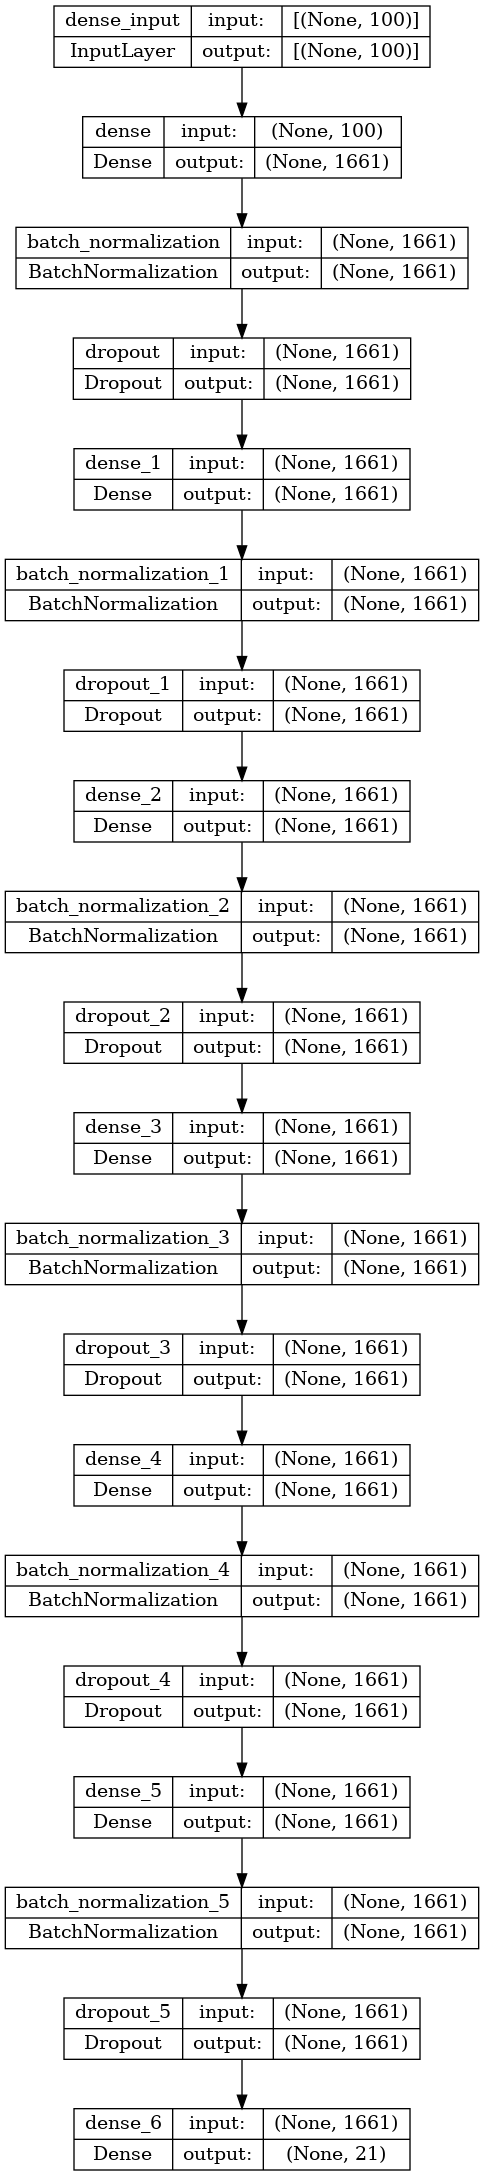

In [27]:
tf.keras.utils.plot_model(best_model, to_file='/kaggle/working/model_mlp.png', show_shapes=True)

## Results

### Learning Curves

In [ ]:
epochs = range(1, len(history.history['accuracy'])+1)

fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].plot(epochs, history.history['loss'], label="train set loss", color='k')
ax[0].plot(epochs, history.history['val_loss'], label="validation set loss", color='red')
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")
ax[0].set_title("training and validation loss")
ax[0].legend()

ax[1].plot(epochs, history.history['accuracy'], label="train set accuracy", color='k')
ax[1].plot(epochs, history.history['val_accuracy'], label="validation set accuracy", color='red')
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("accuracy")
ax[1].legend()

### Accuracy

In [ ]:
start = time.time()
test_loss, test_acc = best_model.evaluate(X_test, y_test)
end = time.time()
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Execution time: {round(end - start, 2):.2f} seconds")

### Confusion Matrix

In [ ]:
# Create a subplot with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

class_names = os.listdir(data_path)

# Train set confusion matrix
y_pred = best_model.predict(X_train)
cm_train = confusion_matrix(y_train.argmax(axis=1), y_pred.argmax(axis=1))

# Plot train set confusion matrix
thresh = cm_train.max() / 2.
for i in range(cm_train.shape[0]):
    for j in range(cm_train.shape[1]):
        axs[0].text(j, i, format(cm_train[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm_train[i, j] > thresh else "black")

im0 = axs[0].imshow(cm_train, interpolation='nearest', cmap=plt.cm.Reds)
fig.colorbar(im0, ax=axs[0])
axs[0].set_xticks(np.arange(num_classes))
axs[0].set_yticks(np.arange(num_classes))
axs[0].set_xticklabels(class_names, rotation=90)
axs[0].set_yticklabels(class_names)
axs[0].set_xlabel('Predicted Label')
axs[0].set_ylabel('True Label')
axs[0].set_title('Confusion Matrix (Train)')

# Validation set confusion matrix
y_pred = best_model.predict(X_val)
cm_val = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))

# Plot validation set confusion matrix
thresh = cm_val.max() / 2.
for i in range(cm_val.shape[0]):
    for j in range(cm_val.shape[1]):
        axs[1].text(j, i, format(cm_val[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm_val[i, j] > thresh else "black")

im1 = axs[1].imshow(cm_val, interpolation='nearest', cmap=plt.cm.Reds)
fig.colorbar(im1, ax=axs[1])
axs[1].set_xticks(np.arange(num_classes))
axs[1].set_yticks(np.arange(num_classes))
axs[1].set_xticklabels(class_names, rotation=90)
axs[1].set_yticklabels(class_names)
axs[1].set_xlabel('Predicted Label')
axs[1].set_ylabel('True Label')
axs[1].set_title('Confusion Matrix (Validation)')

# Test set confusion matrix
y_pred = best_model.predict(X_test)
cm_test = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

# Plot test set confusion matrix
thresh = cm_test.max() / 2.
for i in range(cm_test.shape[0]):
    for j in range(cm_test.shape[1]):
        axs[2].text(j, i, format(cm_test[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm_test[i, j] > thresh else "black")

im2 = axs[2].imshow(cm_test, interpolation='nearest', cmap=plt.cm.Reds)
fig.colorbar(im2, ax=axs[2])
axs[2].set_xticks(np.arange(num_classes))
axs[2].set_yticks(np.arange(num_classes))
axs[2].set_xticklabels(class_names, rotation=90)
axs[2].set_yticklabels(class_names)
axs[2].set_xlabel('Predicted Label')
axs[2].set_ylabel('True Label')
axs[2].set_title('Confusion Matrix (Test)')

# Adjust the layout of subplots
plt.tight_layout()

plt.savefig(f"mlp{1-(val_size+test_size)}_{len(epochs)}e_confusion_matrix.jpg")

# Show the plot
plt.show()